In [1]:
import random
import numpy as np
import copy

In [2]:
def read_instance(filename):

    with open(filename, 'r') as f:
        lines = f.readlines()

    first_line = lines[0].split()
    n = int(first_line[0])
    m = int(first_line[1])

    processing_times = [[0]*m for _ in range(n)]
    for i in range(n):
        line = lines[i+1].split()
        for j in range(m):
            processing_times[i][j] = int(line[j])
    
    last_line = lines[-1].split()
    ub = int(last_line[0])
    lb = int(last_line[1])

    return n, m, processing_times, ub, lb


In [3]:
class Job():

    def __init__(self, job_id, processing_times):
        self.id = job_id
        self.processing_times = processing_times
        self.time_available = 0
        self.remaining_time = sum(processing_times)
        self.remaining_machines = set([i for i in range(len(processing_times))])
        
class Machine():
    def __init__(self, machine_id, processing_times):
        self.id = machine_id
        self.time_available = 0
        self.remaining_time = sum([processing_times[i][machine_id] for i in range(len(processing_times[0]))])
        self.remaining_jobs = set([i for i in range(len(processing_times))])

def update(machine, job, processing_times):
    duration = processing_times[job.id][machine.id]
    end  = max(machine.time_available, job.time_available) + duration
    machine.remaining_time -= duration
    machine.remaining_jobs.remove(job.id)
    machine.time_available = end
    job.remaining_time -= duration
    job.remaining_machines.remove(machine.id)
    job.time_available = end

In [4]:
from itertools import takewhile


def makespan(scheduling, processing_times):
    n = len(scheduling[0])
    m = len(scheduling)
    permutation=[]

    jobs = [Job(i, processing_times[i]) for i in range(n)]
    machines = [Machine(j, processing_times) for j in range(m)]

    for j in range(n):
        machine_candidates = list(takewhile(lambda m: m.time_available == machines[0].time_available, machines))
        if len(machine_candidates)>1:
            machine_candidates.sort(key = lambda m: m.remaining_time, reverse=True)
            machine_candidates = list(takewhile(lambda m: m.remaining_time == machine_candidates[0].remaining_time, machine_candidates))
            if len(machine_candidates)>1:
                job_candidates = [-1 for _ in range(m)]
                for machine in machine_candidates:
                    job_candidates[machine.id] = scheduling[machine.id][j]
                machine_candidates.sort(key = lambda m: jobs[job_candidates[m.id]].remaining_time - processing_times[job_candidates[m.id]][m.id], reverse=True)
        candidates_ids= [machine.id for machine in machine_candidates]
        machines = machine_candidates + [machine for machine in machines if machine.id not in candidates_ids]
        for machine in machines:
            permutation.append(jobs[scheduling[machine.id][j]].id*n+machine.id)
            update(machine, jobs[scheduling[machine.id][j]], processing_times)
            
        machines.sort(key = lambda m: m.time_available)
       
    return (np.max([machine.time_available for machine in machines]), permutation)


In [5]:
from copy import copy

def scheduling(processing_times):
    n = len(processing_times)
    m = len(processing_times[0])
    schedule = [[0]*n for _ in range(m)]
    
    jobs = [Job(i, processing_times[i]) for i in range(n)]
    machines = [Machine(j, processing_times) for j in range(m)]
    
    next_machine_candidates = copy(machines)
    next_machine_candidates.sort(key = lambda m: m.remaining_time, reverse=True)
    first_machine = next_machine_candidates[0]
    job_candidates = copy(jobs)
    job_candidates.sort(key = lambda job: job.remaining_time - processing_times[job.id][first_machine.id], reverse=True)
    first_job = job_candidates[0]
    schedule[first_machine.id][0] = first_job.id
    update(first_machine, first_job, processing_times)
    
    for k in range(1, n*m):

        next_machine_candidates.sort(key = lambda m: m.time_available)
       
        next_job_candidates = []
        for next_machine in next_machine_candidates:
            job_candidates = []
            for job in next_machine.remaining_jobs:
                if jobs[job].time_available<=next_machine.time_available:
                    job_candidates.append((jobs[job],jobs[job].remaining_time-jobs[job].processing_times[next_machine.id]))
            if len(job_candidates)!=0:
                next_machine_id = next_machine.id
                next_job_candidates = copy(job_candidates)
                break
        if len(next_job_candidates)==0:
            for machine in next_machine_candidates: 
                if len(machine.remaining_jobs)!=0:
                    next_machine_id=machine.id
                    break
            remaining_jobs = list(machines[next_machine_id].remaining_jobs)
            remaining_jobs.sort(key = lambda job: jobs[job].remaining_time-jobs[job].processing_times[next_machine_id], reverse=True)
            job = remaining_jobs[0]
            next_job_candidates.append((jobs[job], jobs[job].remaining_time-jobs[job].processing_times[next_machine_id]))
    
        else:
            next_job_candidates.sort(key = lambda job: job[1], reverse=True)

        next_job = next_job_candidates[0][0]
        next_machine = machines[next_machine_id]
        schedule[next_machine.id][len(processing_times)-len(next_machine.remaining_jobs)] = next_job.id
        update(next_machine, next_job, processing_times)
        
    return schedule

In [6]:
from tqdm import tqdm
from copy import deepcopy

def pairwise_exchange_neighborhood(schedule):
    n = len(schedule[0])
    m = len(schedule)
    neighborhood = []
    for i in range(n):
        for j in range(m):
            for k in range(i, n):
                for l in range(j, m):
                    if i == k and j == l:
                        continue
                    neighbor = deepcopy(schedule)
                    if i == k:
                        neighbor[i][j], neighbor[i][l] = neighbor[i][l], neighbor[i][j]
                        neighborhood.append(neighbor)
                        continue
                    
                    row1, row2 = i, k
                    col21 = neighbor[k].index(neighbor[i][j])
                    col22 = neighbor[k].index(neighbor[i][l])
                    neighbor[i][j], neighbor[i][l] = neighbor[k][col21], neighbor[k][col22]
                    neighborhood.append(neighbor)
                    
    return neighborhood
    
    # za n,m=4: neighborhood size 84
    # 5: 200
    # 7: 735
    return neighborhood

def tabu_search(n, m, processing_times, tabu_length, max_iterations, initial_solution, upper_bound):
    best_solution = initial_solution
    best_makespan = makespan(initial_solution, processing_times)[0]
    current_solution = initial_solution
    tabu_list = []
    
    for it in tqdm(range(max_iterations)):
        neighborhood = pairwise_exchange_neighborhood(current_solution)
        best_neighbor = neighborhood[0]
        best_neighbor_makespan = makespan(best_neighbor, processing_times)[0]
        for neighbor in neighborhood[1:]:
            neighbor_makespan = makespan(neighbor, processing_times)[0]
            if neighbor_makespan < best_neighbor_makespan and neighbor not in tabu_list:
                best_neighbor = neighbor
                best_neighbor_makespan = neighbor_makespan
      
        current_solution = best_neighbor
        if best_neighbor_makespan < best_makespan:
            best_solution = best_neighbor
            best_makespan = best_neighbor_makespan
            
        tabu_list.append(best_neighbor)
        if len(tabu_list) > tabu_length:
            tabu_list.pop(0)
        
    return makespan(best_solution, processing_times)


In [8]:
bounds = [(0,0) for _ in range(10)]
results = [0 for _ in range(10)]
for i in range(10):
    instance_file = "tests/test44" + str(i)
    n, m, processing_times, ub, lb = read_instance(instance_file)
    print(processing_times)
    bounds[i] = (lb, ub)
    results[i] = tabu_search(n, m, processing_times, 20, 10000, scheduling(processing_times), ub)
    print(results[i])


[[34, 2, 54, 61], [15, 89, 70, 9], [38, 19, 28, 87], [95, 7, 34, 29]]


100%|█████████████████████████████████████| 10000/10000 [02:34<00:00, 64.80it/s]


(195, [7, 10, 4, 13, 1, 15, 8, 6, 9, 3, 12, 2, 5, 11, 14, 0])
[[45, 83, 70, 5], [80, 45, 58, 24], [29, 56, 29, 61], [74, 45, 64, 43]]


100%|█████████████████████████████████████| 10000/10000 [02:22<00:00, 70.36it/s]


(239, [1, 12, 6, 11, 10, 7, 4, 13, 3, 2, 9, 0, 15, 14, 5, 8])
[[2, 5, 38, 66], [85, 68, 14, 95], [54, 77, 89, 38], [59, 63, 72, 51]]


100%|█████████████████████████████████████| 10000/10000 [02:29<00:00, 66.91it/s]


(284, [11, 0, 5, 14, 8, 3, 9, 6, 2, 12, 7, 13, 10, 4, 15, 1])
[[60, 19, 54, 35], [25, 40, 75, 98], [58, 88, 28, 52], [43, 62, 74, 60]]


 29%|███████████                           | 2920/10000 [00:45<01:49, 64.70it/s]


KeyboardInterrupt: 

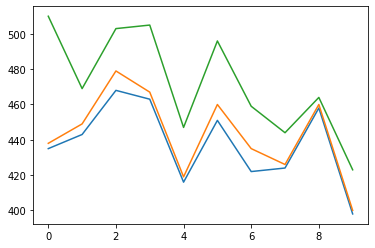

[438, 449, 479, 467, 419, 460, 435, 426, 460, 400]
[510, 469, 503, 505, 447, 496, 459, 444, 464, 423]


In [176]:
from matplotlib import pyplot as plt
plt.plot(range(10), [bounds[i][0] for i in range(10)])
plt.plot(range(10), [bounds[i][1] for i in range(10)])
plt.plot(range(10), [res[0] for res in results])
plt.show()
print([bounds[i][1] for i in range(10)])
print( [res[0] for res in results])

In [ ]:
from itertools import permutations

def brute_force(processing_times):

    perms = list(permutations(range(3)))
    min_makespan = float('inf')

    p = len(perms)

    #3 machines
    for i in range(p):
        for j in range(p):
            for k in range(p):
                solution = []
                solution.append(perms[i])
                solution.append(perms[j])
                solution.append(perms[k])

                time = makespan(solution,processing_times)
                if time < min_makespan:
                    min_makespan = time

    return min_makespan


In [27]:
processing_times= [[[52,13,77], [11,20,42], [7, 44, 32]], 
                   [[40, 5,18], [30,21,14], [8, 37, 16]],
                   [[15,31,72], [19,30,62], [22, 54, 12]],
                   [[19,30,62], [52,13,77], [19, 34, 28]],
                   [[27,32,51], [11,40,20], [71, 40, 60]],
                   [[20,37,77], [61,10,42], [70, 15, 43]],
                   [[12,51,17], [41,20,12], [16, 50, 29]],
                   [[50,10,70], [10,20,40], [70, 40, 30]],
                   [[29,16,67], [43,50,17], [63, 4, 72]],
                   [[34,25,69], [17,80,22], [81, 14, 32]]
    
]


[[[40, 5, 18], [30, 21, 14], [8, 37, 16]],
 [[15, 31, 72], [19, 30, 62], [22, 54, 12]],
 [[19, 30, 62], [52, 13, 77], [19, 34, 28]],
 [[27, 32, 51], [11, 40, 20], [71, 40, 60]],
 [[20, 37, 77], [61, 10, 42], [70, 15, 43]],
 [[12, 51, 17], [41, 20, 12], [16, 50, 29]],
 [[50, 10, 70], [10, 20, 40], [70, 40, 30]],
 [[29, 16, 67], [43, 50, 17], [63, 4, 72]],
 [[34, 25, 69], [17, 80, 22], [81, 14, 32]]]

In [30]:
brute_force_results=[]
tabu_search_results=[]
for times in processing_times:
    brute_force_results.append(brute_force(times))
    tabu_search_results.append(tabu_search(3,3,times,3,1000,scheduling(times),1000))
    
print(brute_force_results)
print([res[1] for res in tabu_search_results])

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 313.18it/s]

[151, 78, 146, 167, 171, 162, 121, 140, 156, 139]
[151, 78, 146, 167, 171, 162, 121, 140, 156, 139]
